In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import urllib.request
import http.cookiejar
from skyfield.sgp4lib import EarthSatellite
import skyfield.api
import datetime

c = 299792458
carrier_freq = 10489.8e6
uplink_freq = 2400.3e6
uplink_relative_doppler = uplink_freq / carrier_freq

In [2]:
def new_figure():
    plt.figure(figsize = (12,6), facecolor='w')

def set_axis_options():
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.grid()

def set_axis_labels():
    plt.xlabel('UTC time')
    plt.ylabel('Doppler (ppb)')

def set_legend():
    plt.legend([f'EA4GPZ measurements of QO-100 BPSK beacon',\
            'TLEs'])

In [3]:
def opener_spacetrack(username, password):
    # todo: clean login info from ipynb file
    cj = http.cookiejar.CookieJar()
    opener = urllib.request.build_opener(urllib.request.HTTPCookieProcessor(cj))
    auth_url = 'https://www.space-track.org/ajaxauth/login/'
    auth_data = urllib.parse.urlencode({'identity' : username, 'password' : password}).encode('utf-8')
    auth_req = urllib.request.Request(auth_url, auth_data)
    r = opener.open(auth_req)
    return opener

def get_tles(opener):
    url = 'https://www.space-track.org/basicspacedata/query/class/tle/EPOCH/%3E2019-11-01/NORAD_CAT_ID/43700/orderby/EPOCH%20ASC/format/tle'
    r = opener.open(url)
    tle_lines = r.read().decode('ascii').split('\r\n')
    return [EarthSatellite(*x) for x in zip(tle_lines[::2], tle_lines[1::2])]

In [4]:
with open('../spacetrack_auth', 'r') as f:
    username, password = f.read().split('\n')[:2]
    opener = opener_spacetrack(username, password)

tles = get_tles(opener)

In [5]:
ts = skyfield.api.load.timescale()

In [6]:
doppler_times = np.arange(np.datetime64('2019-11-20T00:00:00'), np.datetime64('2019-11-24T00:00:00'), np.timedelta64(1, 'm'))
timestamps = (doppler_times - np.datetime64('1970-01-01T00:00:00'))/np.timedelta64(1, 's')
times = ts.utc([datetime.datetime.utcfromtimestamp(t).replace(tzinfo = skyfield.api.utc) for t in timestamps])

In [7]:
cuts = [None] * (len(tles)+1)
cuts[0] = 0
for j in range(len(tles) - 1):
    try:
        cut = np.where(np.abs(times-tles[j].epoch) - np.abs(times-tles[j+1].epoch) > 0)[0][0]
    except IndexError:
        cut = 0
    cuts[j+1] = max(cut, cuts[j])
slices = [slice(a,b) for a,b in zip(cuts[:-1], cuts[1:])]

In [8]:
ea4gpz = skyfield.api.Topos(latitude = 40.595865, longitude = -3.699069, elevation_m = 800)
bochum = skyfield.api.Topos(latitude = 51.426988, longitude = 7.192558, elevation_m = 0)

In [9]:
rvs_ea4gpz = [(eshail2 - ea4gpz).at(times[sl]) for eshail2,sl in zip(tles, slices) if len(times[sl])]
rvs_bochum = [(eshail2 - bochum).at(times[sl]) for eshail2,sl in zip(tles, slices) if len(times[sl])]

In [10]:
dtimes = np.concatenate([doppler_times[sl][:-1] for eshail2,sl in zip(tles, slices) if len(times[sl])])

In [11]:
doppler_ea4gpz = -np.concatenate([np.diff(rv.distance().km) for rv in rvs_ea4gpz])/60*1e3/c
doppler_bochum = -np.concatenate([np.diff(rv.distance().km) for rv in rvs_bochum])/60*1e3/c
# Doppler in parts per one
doppler = xr.Dataset({'ea4gpz' : (['time'], doppler_ea4gpz), 'bochum' : (['time'], doppler_bochum)},\
                           coords = {'time' : dtimes})

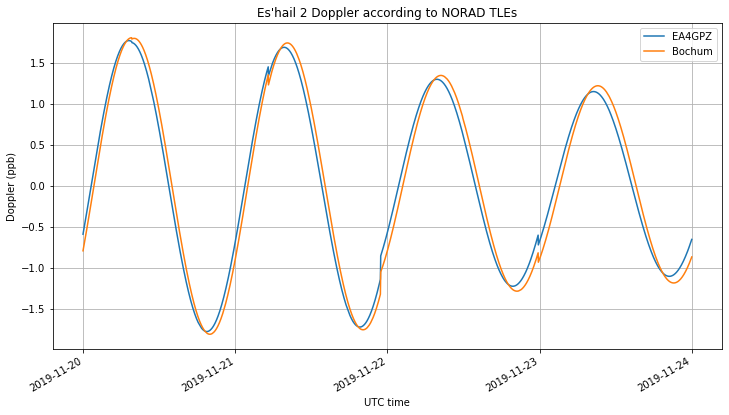

In [12]:
new_figure()
(1e9*doppler['ea4gpz']).plot()
(1e9*doppler['bochum']).plot()
set_axis_options()
plt.title('Es\'hail 2 Doppler according to NORAD TLEs')
set_axis_labels()
plt.legend(['EA4GPZ', 'Bochum']);

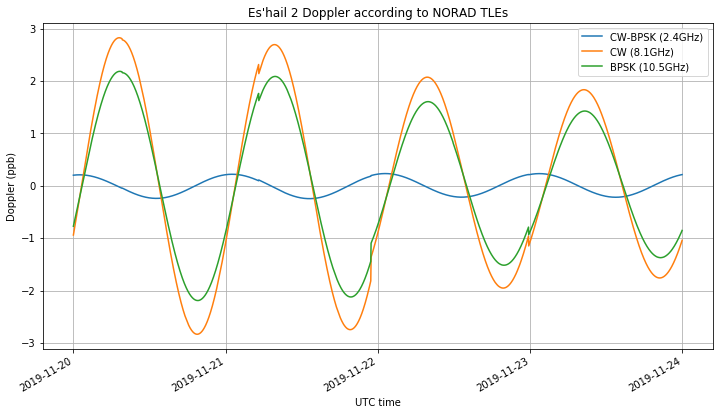

In [13]:
new_figure()
(1e9*(doppler['ea4gpz']-doppler['bochum'])).plot()
(1e9*(carrier_freq+uplink_freq)/(carrier_freq-uplink_freq)*doppler['ea4gpz']).plot()
(1e9*(doppler['ea4gpz'] + uplink_freq/carrier_freq*doppler['bochum'])).plot()
set_axis_options()
plt.title('Es\'hail 2 Doppler according to NORAD TLEs')
set_axis_labels()
plt.legend(['CW-BPSK (2.4GHz)', 'CW (8.1GHz)', 'BPSK (10.5GHz)']);

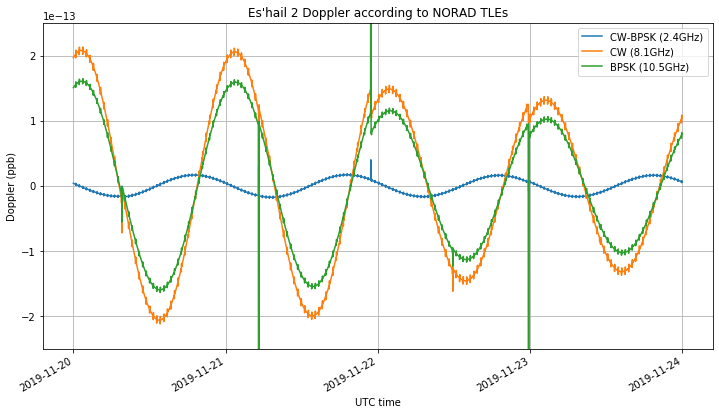

In [22]:
new_figure()
(doppler['ea4gpz']-doppler['bochum']).differentiate('time', datetime_unit = 's').plot()
((carrier_freq+uplink_freq)/(carrier_freq-uplink_freq)*doppler['ea4gpz']).differentiate('time', datetime_unit = 's').plot()
((doppler['ea4gpz'] + uplink_freq/carrier_freq*doppler['bochum'])).differentiate('time', datetime_unit = 's').plot()
set_axis_options()
plt.ylabel('Doppler change rate (1/s)')
plt.ylim((-0.25e-12, 0.25e-12))
plt.title('Es\'hail 2 Doppler according to NORAD TLEs')
set_axis_labels()
plt.legend(['CW-BPSK (2.4GHz)', 'CW (8.1GHz)', 'BPSK (10.5GHz)']);

In [14]:
subpoints = [eshail2.at(times[sl]).subpoint() for eshail2,sl in zip(tles,slices) if len(times[sl])]
longitude = np.concatenate([sp.longitude.degrees for sp in subpoints])
latitude = np.concatenate([sp.latitude.degrees for sp in subpoints])
elevation = np.concatenate([sp.elevation.km for sp in subpoints])

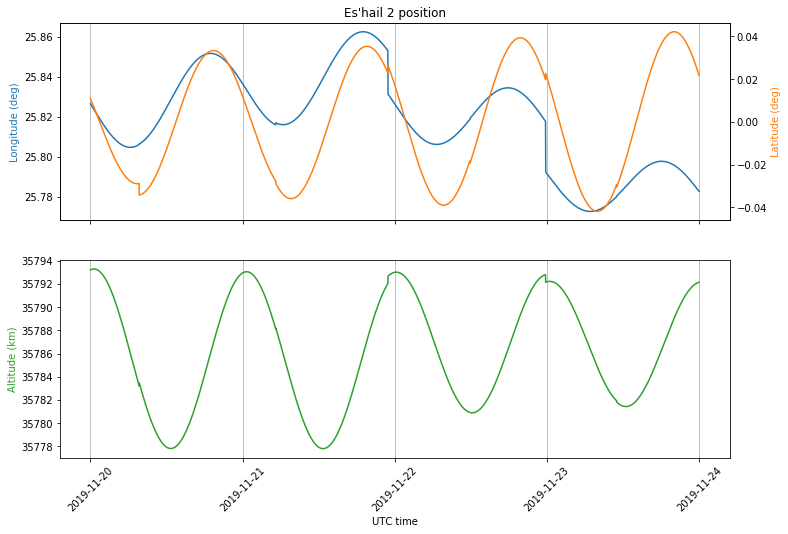

In [15]:
fig, axs = plt.subplots(2, figsize = (12, 8), facecolor = 'w')
ax1 = axs[0]
ax2 = ax1.twinx()
ax3 = axs[1]
ax1.plot(doppler_times, longitude, color = 'C0')
ax2.plot(doppler_times, latitude, color = 'C1')
ax3.plot(doppler_times, elevation, color = 'C2')
ax1.set_ylabel('Longitude (deg)', color = 'C0')
ax2.set_ylabel('Latitude (deg)', color = 'C1')
ax3.set_ylabel('Altitude (km)', color = 'C2')
ax1.set_title('Es\'hail 2 position')
for ax in axs:
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter(''))
    ax.grid(axis = 'x')
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax3.tick_params('x', rotation = 45)
ax3.set_xlabel('UTC time');